# Citibike tripdata insights 

## Analysis Overview

In this analysis, I wanted to look at the some interesting findings from tripdata such as 
* Busiest bike stations in New York
* when are the busiest hours of cycling in New York, and where? 
* Demographics of bike riders in new york 


## Dataset Overview

The data used in this document include all bike trips recorded from September,1st 2020 until October, 13th 2020. The dataset includes 53754 trips, with the following features:

* Trip Duration (seconds)
* Start Time and Date
* Stop Time and Date
* Start Station Name
* End Station Name
* Station ID
* Station Lat/Long
* Bike ID
* User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
* Gender (Zero=unknown; 1=male; 2=female)
* Year of Birth

*Note on data as shared by citibike: data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations (which we were using more in June and July 2013), and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).*

In [2]:
#import needed packages 
import pandas as pd
import numpy as np
import matplotlib as mt
import seaborn as sb
import matplotlib.pyplot as plt
!conda install -y -c conda-forge folium
import folium

%matplotlib inline

Solving environment: ...working... done

# All requested packages already installed.



In [24]:
# load in the dataset into a pandas dataframe
df=pd.read_csv('NY 202010-citibike-tripdata.csv')
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1403,2020-10-01 00:00:10.7870,2020-10-01 00:23:34.5400,224,Spruce St & Nassau St,40.711464,-74.005524,3347,Van Brunt St & Wolcott St,40.677343,-74.012751,39079,Subscriber,1995,1
1,462,2020-10-01 00:00:18.2390,2020-10-01 00:08:00.5710,3161,W 76 St & Columbus Ave,40.780184,-73.977285,3158,W 63 St & Broadway,40.771639,-73.982614,41267,Subscriber,1998,2
2,770,2020-10-01 00:00:21.3070,2020-10-01 00:13:12.0840,354,Emerson Pl & Myrtle Ave,40.693631,-73.962236,3761,Cedar St & Myrtle Ave,40.697842,-73.926241,47398,Customer,1996,1
3,233,2020-10-01 00:00:25.0080,2020-10-01 00:04:18.6410,3141,1 Ave & E 68 St,40.765005,-73.958185,464,E 56 St & 3 Ave,40.759345,-73.967597,36482,Subscriber,1993,1
4,126,2020-10-01 00:00:25.3100,2020-10-01 00:02:32.1330,335,Washington Pl & Broadway,40.729039,-73.994046,229,Great Jones St,40.727434,-73.993790,45319,Subscriber,1989,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248864,1120,2020-10-31 23:59:48.4470,2020-11-01 00:18:29.3280,471,Grand St & Havemeyer St,40.712868,-73.956981,3764,Bushwick Ave & McKibbin St,40.705517,-73.939360,35356,Customer,1996,1
2248865,859,2020-10-31 23:59:49.3770,2020-11-01 00:14:09.1920,4005,St. Nicholas Terrace & Convent Ave,40.821294,-73.947868,3960,Hamilton Pl & W 140 St,40.822756,-73.951346,48322,Customer,1999,1
2248866,546,2020-10-31 23:59:52.1040,2020-11-01 00:08:59.0710,4010,W 145 St & Amsterdam Ave,40.825244,-73.947257,4057,Amsterdam Ave & W 167 St,40.839443,-73.937044,44589,Subscriber,1976,1
2248867,748,2020-10-31 23:59:53.0290,2020-11-01 00:12:21.7830,3783,Cliff St & Fulton St,40.708380,-74.004950,432,E 7 St & Avenue A,40.726218,-73.983799,48511,Subscriber,1997,2


In [25]:
#Data wrangling trips which are longer than 24 hours. 
# make a copy of the dataframe 
#CODE: fix dtypes

dfc = df.copy()
dfc['starttime'] = pd.to_datetime(dfc['starttime'])
dfc['stoptime'] = pd.to_datetime(dfc['stoptime'])

dfc['start station id'] = dfc['start station id'].astype('str')
dfc['end station id'] = dfc['end station id'].astype('str')
dfc['bikeid'] = dfc['bikeid'].astype('str')

dfc['usertype'] = dfc['usertype'].astype('category')
dfc['gender'] = dfc['gender'].astype('category')

dfc.info(null_counts=True)

#CODE: add new columns for trip duration in minute, trip start date in yyyy-mm-dd format, trip start hour of the day, day of week and month

dfc['duration_minute'] = dfc['tripduration']/60

dfc['start_date'] = dfc.starttime.dt.strftime('%Y-%m-%d')
dfc['start_hourofday'] = dfc.starttime.dt.strftime('%H')
dfc['start_dayofweek'] = dfc.starttime.dt.strftime('%A')
dfc['start_month'] = dfc.starttime.dt.strftime('%B')

dfc.tail()

#CODE:replace gender values with text 
dfc['gender']= dfc['gender'].replace(0, 'unknown')
dfc['gender']=dfc['gender'].replace(1, 'Male')
dfc['gender']=dfc['gender'].replace(2, 'Female')

#columns Age and Counts 
dfc['age'] = 2021-dfc['birth year']
dfc['Counts'] = dfc.groupby(['start station id'])['start station name'].transform('count')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248869 entries, 0 to 2248868
Data columns (total 15 columns):
tripduration               2248869 non-null int64
starttime                  2248869 non-null datetime64[ns]
stoptime                   2248869 non-null datetime64[ns]
start station id           2248869 non-null object
start station name         2248869 non-null object
start station latitude     2248869 non-null float64
start station longitude    2248869 non-null float64
end station id             2248869 non-null object
end station name           2248869 non-null object
end station latitude       2248869 non-null float64
end station longitude      2248869 non-null float64
bikeid                     2248869 non-null object
usertype                   2248869 non-null category
birth year                 2248869 non-null int64
gender                     2248869 non-null category
dtypes: category(2), datetime64[ns](2), float64(4), int64(2), object(5)
memory usage: 227.3+ MB


## Distribution of Trip Durations
The following histogram plots show that the hishest number of rides are actually fall into the (<b>5-10 minutes</b> tripduration) range. The average of citibike rides in New York is <b>12.5 Minutes</b>. 

12.55

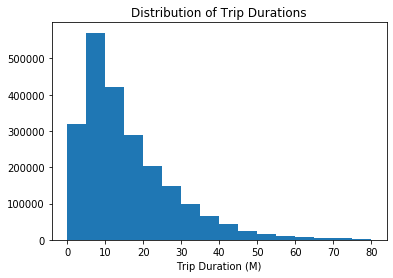

In [8]:
bins=np.arange(0,dfc['duration_minute'].quantile(0.99) + 5,  5)
plt.hist(data = dfc, x = 'duration_minute',bins=bins);
plt.title('Distribution of Trip Durations');
plt.xlabel('Trip Duration (M)');
dfc['duration_minute'].median()

## Demographics of Bike Riders
The data shows that almost 67% of bike riders are Male, while only 33% are Female..

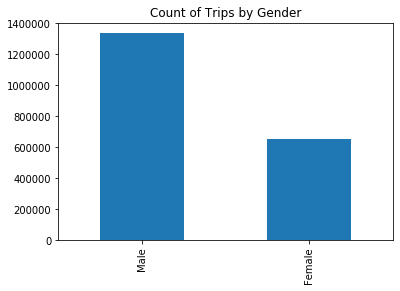

In [14]:
dfg=dfc[dfc['gender'] != 'unknown' ]
dfg['gender'].value_counts().plot(kind='bar', title='Count of Trips by Gender');

..however Female riders have higher mean of tripduration.

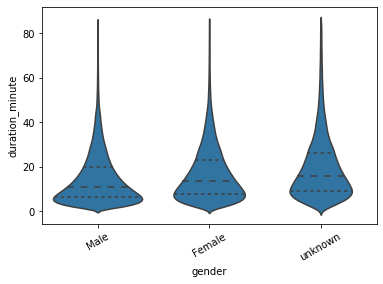

In [21]:
dfg=dfc[dfc['duration_minute'] < 85]
base_color = sb.color_palette()[0]
sb.violinplot(data=dfg, x='gender', y='duration_minute', color=base_color, inner='quartile')
plt.xticks(rotation=30);

Another interesting finding, is that the third top age group of riders is 50 to 55 Years old riders 

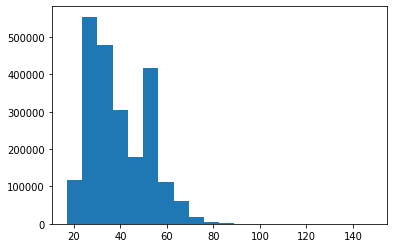

In [20]:
plt.hist(data = dfc, x = 'age',bins=20);

## Busiest Bike Stations
The stations with the highest number of trips are actually not condensed in one area, but they are all in Manhattan 

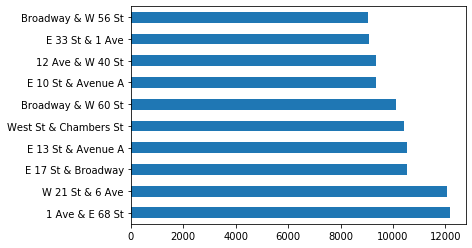

In [22]:
dfc['start station name'].value_counts()[:10].plot(kind='barh');
top_stations=dfc['start station name'].value_counts()[:10]

In [26]:
#create a dataframe of only top 10 stations by count of trips 
dfx=dfc.drop_duplicates(subset=['start station name'])
dfx_10=dfx.nlargest(10,'Counts')

# Make an empty map
m = folium.Map(location=[40.747391,-73.971139],tiles='OpenStreetMap',zoom_start=12)
# Adding markers on the map
for i in range(len(dfx_10)):
   folium.features.CircleMarker(
      location=[dfx_10.iloc[i]['start station latitude'], dfx_10.iloc[i]['start station longitude']],
      popup=dfx_10.iloc[i]['start station name'],
      radius=10,
      color='blue',
      fill=True,
      fill_color='blue'
).add_to(m)
 
# Save it as html
#m.save('mymap.html')
m

The following map shows all bike stations by location. Big sized cicrcles indicate higher number of trips initiated at these stations. 

In [31]:
#Starting station locations
import folium

# Make an empty map
m = folium.Map(location=[40.747391,-73.971139],tiles='OpenStreetMap',zoom_start=13)
# Adding markers on the map
for i in range(len(dfx)):
   folium.features.CircleMarker(
      location=[dfx.iloc[i]['start station latitude'], dfx.iloc[i]['start station longitude']],
      popup=dfx.iloc[i]['start station name'],
      radius=dfx.iloc[i]['Counts']/1000,
      color='#4E79A7',
      fill=True,
      fill_color='#4E79A7',
      fill_opacity=1
).add_to(m)
m

## Variations of Trip Duration 
Between customer and Subscriber, the plot below shows they both have same trends of Tripduration Average variations during the week. The peak for both user types are on Saturdays and Sundays. 

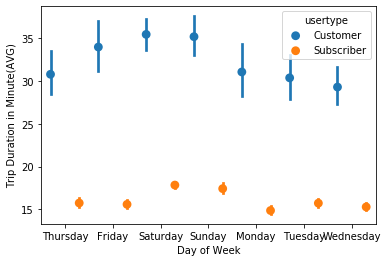

In [29]:
sb.pointplot(data=dfc, x='start_dayofweek', y='duration_minute', hue='usertype', dodge=0.6, linestyles="");
plt.xlabel('Day of Week');
plt.ylabel('Trip Duration in Minute(AVG)');